LOOCV: TF-IDF features + RF

In [1]:
import pandas as pd
from pandas import read_csv

import numpy as np
from numpy import mean, std

from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
euct_df = pd.read_csv('c:\\Users\\s2421127\\Documents\\NLP Project\\ObuayaO\\NLP project\\Chapter 3\\euct_ns.csv', encoding='unicode_escape') 
# Data already preprocess since classification tasks

LOOCV

In [3]:
euct_df['concat_corpus'] = euct_df['Title']+ " " + euct_df['Objective'] + " " + euct_df['pr_endpoint'] + " " + euct_df['endpoint_description']
euct_df.head()

,EudraCT_No,Title,Phase,Objective,End_date,Sample_size,pr_endpoint,endpoint_description,Treatment,LT_followup,manual_label,concat_corpus
0,2018-003243-39,phase 3 randomized double blind placebo contro...,3,primary purpose study evaluate safety efficacy...,NaN,175,change baseline myasthenia gravis activity dai...,mg adl 8 point questionnaire focusing relevant...,Ravulizumab,No,0,phase 3 randomized double blind placebo contro...
1,2009-016138-29,randomized multicenter open label phase iii st...,iii,compare efficacy plitidepsin combination dexam...,20-Nov-17,255,progression free survival independent review c...,primary study analysis based externally assess...,Aplidin,No,2,randomized multicenter open label phase iii st...
2,2016-000474-38,multicenter 2 cohort trial first as pharmacoki...,0,demonstrate fenfluramine hydrochloride superio...,05-Jun-18,87,change convulsive seizure frequency csf baseli...,baseline adjusted csf mean number convulsive s...,fenfluramine hydrochloride,Yes,0,multicenter 2 cohort trial first as pharmacoki...
3,2014-000418-75,multicenter multinational randomized double bl...,0,primary objective study as efficacy laquinimod...,19-Jun-18,352,change baseline uhdrs tm week 52,uhdrs as motor function cognition behaviour fu...,Placebo,No,0,multicenter multinational randomized double bl...
4,2012-002933-12,phase ii pilot study explore treatment sodium ...,ii,determine whether patient taking medicine call...,10-Dec-18,8,workload,participant cycled cycle ergometer oxygen cons...,Sodium Valproate,No,1,phase ii pilot study explore treatment sodium ...


In [4]:
# Fill NaN values with an empty string
euct_df['concat_corpus'] = euct_df['concat_corpus'].fillna('')

In [5]:
vectorizer = TfidfVectorizer(analyzer='word', min_df=10, ngram_range=(1,3))
tfidf_matrix = vectorizer.fit_transform(euct_df['concat_corpus'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

In [6]:
X = tfidf_df
y = euct_df['manual_label'].values

In [7]:
print("Initial DataFrame shape:", euct_df.shape)
euct_df.dropna(subset=['concat_corpus', 'manual_label'], inplace=True)  # Drop rows with NaN values in relevant columns
print("Shape after dropping NaNs:", euct_df.shape)

Initial DataFrame shape: (190, 12)
Shape after dropping NaNs: (190, 12)


In [8]:
print(f'Features shape: {X.shape}, Target shape: {y.shape}')

Features shape: (190, 353), Target shape: (190,)


In [9]:
if X.shape[0] != y.shape[0]:
    raise ValueError("Features and target variable have inconsistent number of samples.")

In [12]:
from sklearn.model_selection import GridSearchCV

parameters = {'randomforestclassifier__n_estimators': (50, 100, 200), 'randomforestclassifier__criterion': ['gini', 'entropy'], 'randomforestclassifier__max_depth': [None, 10, 20], 'randomforestclassifier__min_samples_split': [2, 5, 10], 'randomforestclassifier__min_samples_leaf': [2, 5, 10], 'randomforestclassifier__random_state': [42]}

rfc = RandomForestClassifier()
pipeline = make_pipeline(StandardScaler(), rfc)
rfc = GridSearchCV(pipeline, parameters, cv=10)
rfc.fit(X, y)

# Display the best parameters found by GridSearchCV
print("Best parameters found: ", rfc.best_params_)

Best parameters found:  {'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': 10, 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__min_samples_split': 5, 'randomforestclassifier__n_estimators': 50, 'randomforestclassifier__random_state': 42}


In [13]:
loo = LeaveOneOut()
predictions = []
actuals = []

In [14]:
rfc = RandomForestClassifier(n_estimators = 50, criterion='entropy', max_depth=10, min_samples_split =5, min_samples_leaf=2,  random_state = 42)

In [15]:
for train_index, test_index in loo.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    rfc.fit(X_train, y_train)

    y_pred = rfc.predict(X_test)

    predictions.append(y_pred[0])
    actuals.append(y_test[0])

In [16]:
from sklearn.metrics import classification_report
accuracy_weighted = accuracy_score(actuals, predictions)
precision_weighted = precision_score(actuals, predictions, average='weighted')
recall_weighted = recall_score(actuals, predictions, average='weighted')
f1_weighted = f1_score(actuals, predictions, average='weighted')

accuracy_unweighted = accuracy_score(actuals, predictions)
classification_metrics = classification_report(actuals, predictions, output_dict=True)

# Print metrics
print(f'LOOCV Accuracy (Weighted): {accuracy_weighted:.2f}')
print(f'LOOCV Precision (Weighted): {precision_weighted:.2f}')
print(f'LOOCV Recall (Weighted): {recall_weighted:.2f}')
print(f'LOOCV F1 Score (Weighted): {f1_weighted:.2f}')
print()

print(f'LOOCV Accuracy (Unweighted): {accuracy_unweighted:.2f}')
print("Precision, Recall, and F1 Score by Class:")
for cls, metrics in classification_metrics.items():
    if cls.isdigit():  # Filter class-specific metrics
        print(f"  Class {cls}: Precision={metrics['precision']:.2f}, Recall={metrics['recall']:.2f}, F1 Score={metrics['f1-score']:.2f}")

# Calculate mean and standard deviation of precision, recall, and F1 scores across classes
class_precisions = [metrics['precision'] for cls, metrics in classification_metrics.items() if cls.isdigit()]
class_recalls = [metrics['recall'] for cls, metrics in classification_metrics.items() if cls.isdigit()]
class_f1_scores = [metrics['f1-score'] for cls, metrics in classification_metrics.items() if cls.isdigit()]

print()
print(f'Mean and Standard Deviation of Precision: Mean={np.mean(class_precisions):.2f}, Std={np.std(class_precisions):.2f}')
print(f'Mean and Standard Deviation of Recall: Mean={np.mean(class_recalls):.2f}, Std={np.std(class_recalls):.2f}')
print(f'Mean and Standard Deviation of F1 Score: Mean={np.mean(class_f1_scores):.2f}, Std={np.std(class_f1_scores):.2f}')

LOOCV Accuracy (Weighted): 0.72
LOOCV Precision (Weighted): 0.66
LOOCV Recall (Weighted): 0.72
LOOCV F1 Score (Weighted): 0.65

LOOCV Accuracy (Unweighted): 0.72
Precision, Recall, and F1 Score by Class:
  Class 0: Precision=0.70, Recall=0.98, F1 Score=0.82
  Class 1: Precision=0.00, Recall=0.00, F1 Score=0.00
  Class 2: Precision=0.94, Recall=0.40, F1 Score=0.56

Mean and Standard Deviation of Precision: Mean=0.55, Std=0.40
Mean and Standard Deviation of Recall: Mean=0.46, Std=0.40
Mean and Standard Deviation of F1 Score: Mean=0.46, Std=0.34


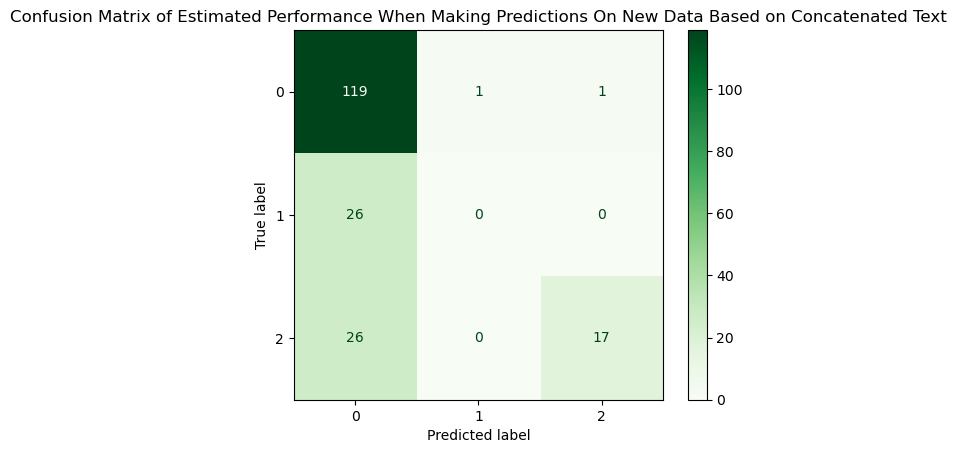

In [17]:
conf_matrix = confusion_matrix(actuals, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=rfc.classes_)
disp.plot(cmap=plt.cm.Greens)
plt.title('Confusion Matrix of Estimated Performance When Making Predictions On New Data Based on Concatenated Text')
plt.show()